<a href="https://colab.research.google.com/github/salil06/SalilModak/blob/main/Recruiter_Clustering_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'adventus-analytics'
location = 'asia-southeast1'
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [ ]:
query='''WITH

orders AS (
SELECT a.order_rcvd_timestamp,
a.student_id,
a.course_id
FROM `adventus-analytics.dw_v2_mv.orders_mv` a
WHERE a.order_rcvd_timestamp>'2022-12-31' AND a.latest_stage='census'
),

course_search AS
(
  SELECT a.student_id,
  a.user_id,
  a.course_id,
  CAST(a.event_timestamp AS DATE) search_date,
  a.search_guid
  FROM `adventus-analytics.dw_v2.course_search` a
  WHERE a.event_timestamp>'2022-12-31' AND (time_to_next_search_secs >= 5 or time_to_next_search_secs is null)
  --GROUP BY 1,2,3,4
),

course_search_count AS
(
  SELECT
  a.user_id,
  COUNT(DISTINCT a.search_guid) total_search,
  COUNT(DISTINCT CASE WHEN a.student_id=0 THEN a.search_guid END) studentless_search,
  FROM `adventus-analytics.dw_v2.course_search` a
  WHERE a.event_timestamp>'2022-12-31' AND (time_to_next_search_secs >= 5 or time_to_next_search_secs is null)
  GROUP BY 1
),

student_count AS
(
  SELECT a.user_id,
  COUNT(DISTINCT CASE WHEN a.student_id <>0 THEN a.student_id END) student_count
  FROM `adventus-analytics.dw_v2.course_search` a
  WHERE a.event_timestamp>'2022-12-31' AND (time_to_next_search_secs >= 5 or time_to_next_search_secs is null)
  GROUP BY 1
),

course_save AS
(
SELECT cs.student_id,
cs.course_id,
cs.saved_date,
c.user_id
FROM `adventus-analytics.dw_v2.course_student_shortlist` cs
LEFT JOIN course_search c
ON c.student_id = cs.student_id AND c.search_date = cs.saved_date AND cs.course_id = c.course_id
WHERE cs.saved_date IS NOT NULL
),



course_shortlisted AS
(
SELECT cs.student_id,
cs.course_id,
cs.shortlisted_date,
c.user_id
FROM `adventus-analytics.dw_v2.course_student_shortlist` cs
LEFT JOIN course_search c
ON c.student_id = cs.student_id AND c.search_date = cs.shortlisted_date AND cs.course_id = c.course_id
WHERE cs.shortlisted_date IS NOT NULL
),

course_save_shortlist AS

(
  SELECT c.user_id,
  COUNT(*) saved_courses,
  COUNT(CASE WHEN cs.shortlisted_date IS NOT NULL THEN cs.course_id END) sl_count,
  COUNT(DISTINCT o.order_rcvd_timestamp) ordered_courses
  FROM course_save c
  LEFT JOIN course_shortlisted cs
  ON c.student_id = cs.student_id AND c.saved_date>=cs.shortlisted_date AND cs.course_id = c.course_id
  LEFT JOIN orders o
  ON c.student_id = o.student_id
  GROUP BY 1
)


SELECT se.*,
SUM(csc.total_search) total_search,
SUM(csc.studentless_search) studentless_search,
SUM(saved_courses) courses_saved,
SUM(sl_count) courses_shortlisted,
SUM(ordered_courses) ordered_courses
FROM student_count se
LEFT JOIN course_search_count csc
ON se.user_id = csc.user_id
LEFT JOIN course_save_shortlist css
ON se.user_id = css.user_id
GROUP BY 1,2
'''

In [ ]:
query_job = client.query(query)
rows = query_job.result()
df=rows.to_dataframe()
df.columns

Index(['user_id', 'student_count', 'total_search', 'studentless_search',
       'courses_saved', 'courses_shortlisted', 'ordered_courses'],
      dtype='object')

In [ ]:
df['user_id']=df['user_id'].astype('int')
df.head(10)

user_id  student_count  total_search  studentless_search  courses_saved  \
0     8975             37          1253                 574             92   
1    13094              4           889                 867              7   
2    11241              7           747                 640            119   
3     5807              1           157                 129             66   
4    16530             31          1284                 428            709   
5    13799            124          1647                 341            746   
6    18065             68          2594                 644           2240   
7    20620              2            31                  13             89   
8    17799              3           156                  36            257   
9    11521              1           416                 412              2   

   courses_shortlisted  ordered_courses  
0                   75                1  
1                    7                0  
2                   94                0  
3                   58                0  
4                  485                0  
5                  633                0  
6                 1353                0  
7                   89                0  
8                  248                0  
9                    1                0

In [ ]:
df_agg = df.groupby('ordered_courses').agg(
    user_count=('user_id','nunique'),
    course_searches = ('student_count','mean'),
    course_save = ('courses_saved','mean'),
    studentless_search = ('studentless_search','sum')
).reset_index()

Text(0.5, 1.0, 'Recruiter Count By number of orders completed')

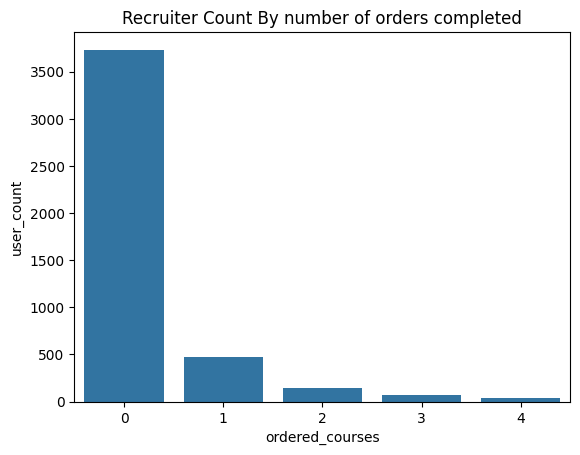

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=df_agg['ordered_courses'][:5],y=df_agg['user_count'][:5])
plt.title('Recruiter Count By number of orders completed')

In [ ]:
df.fillna(0,inplace=True)

<Axes: >

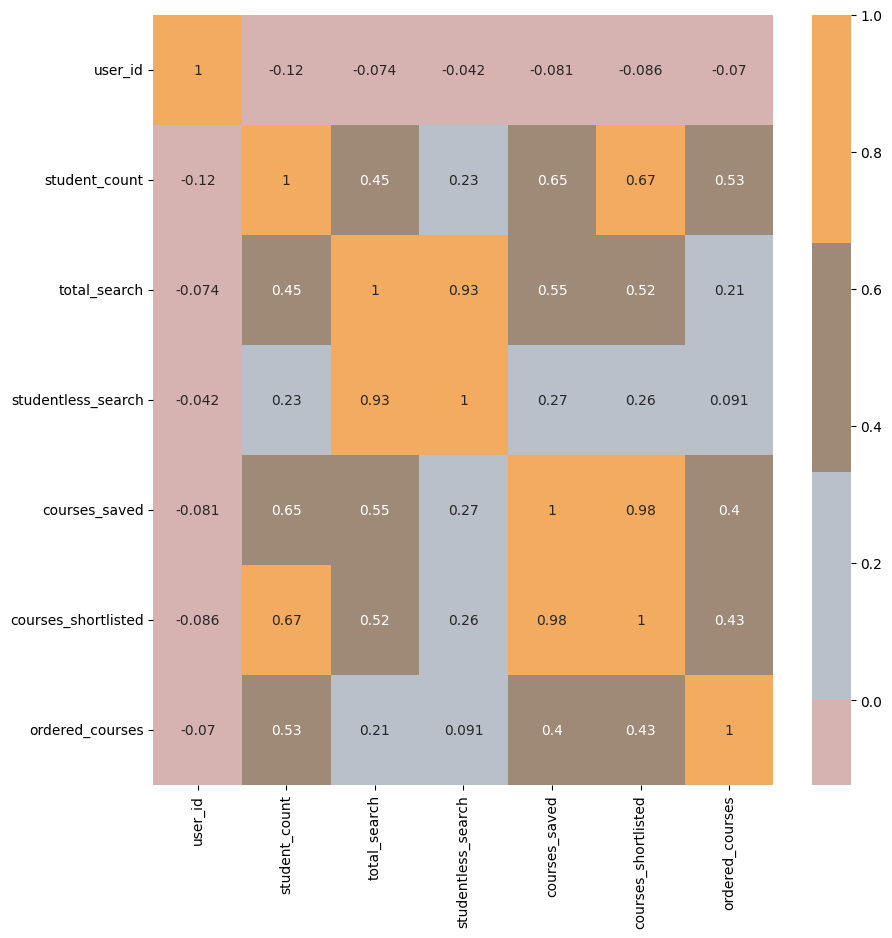

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

corrmat= df.corr()
cmap = ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
plt.figure(figsize=(10,10))
sns.heatmap(corrmat,annot=True,cmap=cmap,center=0)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['student_count', 'total_search', 'studentless_search','courses_saved', 'courses_shortlisted', 'ordered_courses']]))


In [ ]:
pca = PCA(n_components=3)
pca.fit(df_scaled)
PCA_ds = pd.DataFrame(pca.transform(df_scaled), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

count          mean       std        min       25%       50%       75%  \
col1  8719.0  2.607795e-17  1.864722  -0.660301 -0.632857 -0.534690 -0.126190   
col2  8719.0 -2.118834e-17  1.180203 -29.300593 -0.003410  0.128695  0.161595   
col3  8719.0 -1.385391e-17  0.846699 -16.573293  0.002743  0.016288  0.048216   

            max  
col1  56.962048  
col2  31.968342  
col3  32.331616

In [ ]:
# @title
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

In [ ]:
# @title
from sklearn.cluster import AgglomerativeClustering
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df["Clusters_agglomerative"]= yhat_AC

In [ ]:
# @title
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

In [ ]:
# @title
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters_agglomerative"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [ ]:
# @title
pl = sns.scatterplot(data = df,x=df["ordered_courses"], y=df["total_search"],hue=df["Clusters_agglomerative"], palette= pal)
pl.set_title("Cluster's Profile Based On Order And Student Count")
plt.legend()
plt.show()

#Kmeans

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")


# Consider multiple clustering algorithms: KMeans and DBSCAN
kmeans = KMeans(n_clusters=4, random_state=88)
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit both models and evaluate
kmeans.fit(PCA_ds)
dbscan.fit(PCA_ds)

kmeans_silhouette_score = silhouette_score(df_scaled, kmeans.labels_)
dbscan_silhouette_score = silhouette_score(df_scaled, dbscan.labels_)

print(f"KMeans Silhouette score: {kmeans_silhouette_score}")
print(f"DBSCAN Silhouette score: {dbscan_silhouette_score}")

# Choose the model with better Silhouette score or explore both
if kmeans_silhouette_score > dbscan_silhouette_score:
    chosen_model = kmeans
    chosen_labels = chosen_model.labels_
    chosen_score = kmeans_silhouette_score
    print("Choosing KMeans for clustering")
else:
    chosen_model = dbscan
    chosen_labels = chosen_model.labels_
    chosen_score = dbscan_silhouette_score
    print("Choosing DBSCAN for clustering")

# Add cluster labels to the DataFrame
df["cluster"] = chosen_labels
# cluster_labels_ = [f"Cluster {i+1}" for i in range(chosen_model.n_clusters)]
# # Visualization using PCA (consider other options based on data and needs)
# pca = PCA(n_components=2)
# df_pca = pd.DataFrame(pca.fit_transform(df_scaled))
# df_pca.columns =["PC1","PC2"]

# plt.scatter(df_pca["PC1"], df_pca["PC2"], c=chosen_labels, cmap="tab20",label=cluster_labels_)
# plt.title("User Engagement Clusters (PCA & Scatter Plot)")
# plt.legend(title="Cluster")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.show()
temp_df=pd.DataFrame()
# Analyze and interpret clusters
for cluster_id in range(chosen_model.n_clusters):
    cluster_df = df[df["cluster"] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    for col in df.columns[1:]:  # Analyze relevant engagement metrics, excluding user_id
        print(f"{col.replace('_', ' ')}: {cluster_df[col].mean()}")
        #temp_df=temp_df.append(pd.DataFrame({'cluster_id':[cluster_id],'feature':[col],'feature_value':[cluster_df[col].mean()]}))
        temp_df=pd.concat([temp_df,pd.DataFrame({'cluster_id':[cluster_id],'feature':[col],'feature_value':[cluster_df[col].mean()]})], ignore_index=True)

KMeans Silhouette score: 0.8089071975766433
DBSCAN Silhouette score: 0.7500892978876958
Choosing KMeans for clustering

Cluster 0:
student count: 84.42307692307692
total search: 9717.115384615385
studentless search: 8363.384615384615
courses saved: 550.4230769230769
courses shortlisted: 473.5
ordered courses: 2.576923076923077
cluster: 0.0

Cluster 1:
student count: 3.6298805271585173
total search: 156.82436260623228
studentless search: 113.92745411996552
courses saved: 21.669786919571376
courses shortlisted: 17.282423943835447
ordered courses: 0.11011208276881389
cluster: 1.0

Cluster 2:
student count: 295.52
total search: 4161.0
studentless search: 1167.72
courses saved: 2256.76
courses shortlisted: 2040.32
ordered courses: 28.2
cluster: 2.0

Cluster 3:
student count: 49.67030965391621
total search: 1534.0710382513662
studentless search: 913.2222222222222
courses saved: 420.41712204007285
courses shortlisted: 353.8032786885246
ordered courses: 2.2987249544626596
cluster: 3.0


In [ ]:
df['cluster']=df['cluster'].map({0:'average performing',1:'low performing',2:'high performing',3:'above average'})

In [ ]:
#df[['user_id','cluster']]
from pandas_gbq import to_gbq
project_id = "adventus-analytics"
table_id = "user_adityaa.recruiter_persona"
to_gbq(df[['user_id','cluster']], destination_table=table_id, project_id=project_id, if_exists='append')

100%|██████████| 1/1 [00:00<00:00, 2857.16it/s]


In [ ]:
# df_agg['avg_student_count']=df_agg['student_count']/df_agg['user_count']
# df_agg['avg_total_search']=df_agg['total_search']/df_agg['user_count']
# df_agg['avg_courses_shortlisted']=df_agg['courses_shortlisted']/df_agg['user_count']
# df_agg['avg_courses_saved']=df_agg['course_save']/df_agg['user_count']
# df_agg['avg_studentless_search']=df_agg['studentless_search']/df_agg['user_count']
# df_agg['avg_ordered_courses']=df_agg['ordered_courses']/df_agg['user_count']

In [ ]:
PCA_ds['cluster']=chosen_labels

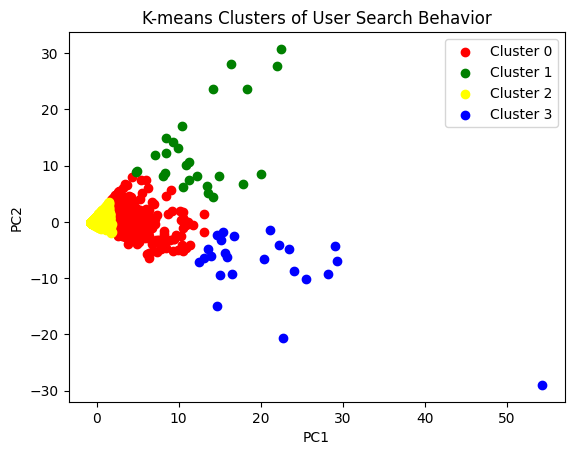

In [ ]:
colors = ["red","green","yellow","blue","orange"]
for i, cluster in enumerate(PCA_ds["cluster"].unique()):
    cluster_data = PCA_ds[PCA_ds["cluster"] == cluster]
    plt.scatter(cluster_data["col1"], cluster_data["col2"], c=colors[i], label=f"Cluster {cluster }")

# Add labels and title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means Clusters of User Search Behavior")

# Add legend
plt.legend(['Cluster 0','Cluster 1','Cluster 2','Cluster 3'])
# Show the plot
plt.show()

In [ ]:
df

user_id  student_count  total_search  studentless_search  courses_saved  \
0        8975             37          1253                 574             92   
1       13094              4           889                 867              7   
2       11241              7           747                 640            119   
3        5807              1           157                 129             66   
4       16530             31          1284                 428            709   
...       ...            ...           ...                 ...            ...   
8714    20585              0            14                  14              0   
8715     8483              0             3                   3              0   
8716     3477              0             6                   6              0   
8717     8112              1             1                   0              0   
8718    12789              0             1                   1              0   

      courses_shortlisted  ordered_courses  cluster  
0                      75                1        1  
1                       7                0        1  
2                      94                0        1  
3                      58                0        1  
4                     485                0        3  
...                   ...              ...      ...  
8714                    0                0        1  
8715                    0                0        1  
8716                    0                0        1  
8717                    0                0        1  
8718                    0                0        1  

[8719 rows x 8 columns]

TypeError: unsupported operand type(s) for *: 'Rectangle' and 'float'

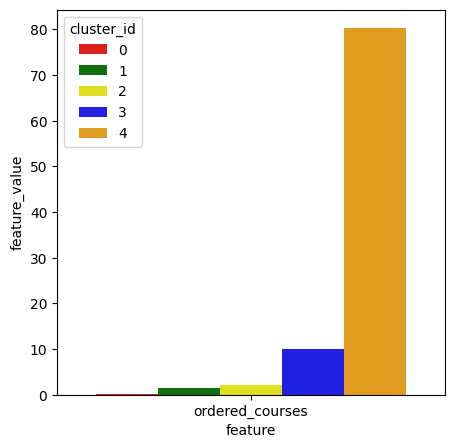

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

t = temp_df.loc[temp_df['feature']=='ordered_courses',]
plt.figure(figsize=(5, 5))
color=["red","green","yellow","blue"]
ax = sns.barplot(x='feature', y='feature_value',hue='cluster_id', palette=colors, data=t)
for i in ax.containers:
    m = np.round(i,2)
    ax.bar_label(m,)
plt.title('Average Courses Ordered by Cluster')

Elbow Method to determine the number of clusters to be formed:


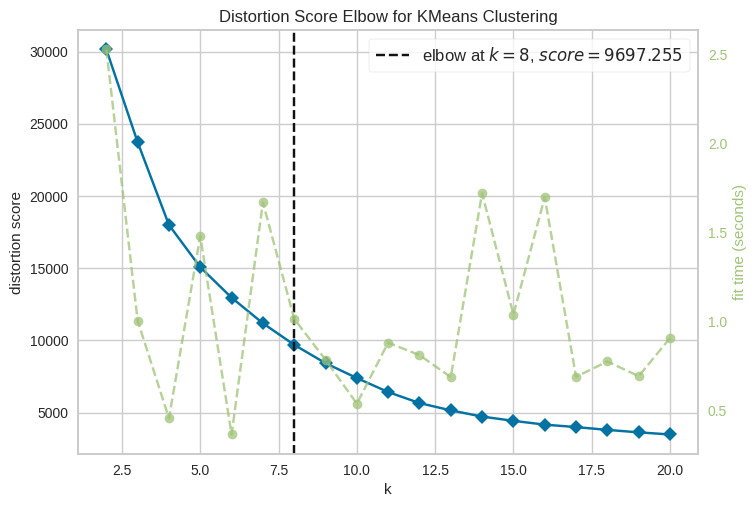

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=20)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [ ]:
df.head(10)

user_id  student_count  total_search  studentless_search  courses_saved  \
0    17385             25          2179                 766            873   
1    15163              0          5094                5094              0   
2     6109             44          1060                 630            275   
3      931              6           418                 345             27   
4    16400            112           214                   3              0   
5     5439             43           343                 120             75   
6    17954              0           186                 186              0   
7     7818             46           464                 216             15   
8    17583             32           773                 191            287   
9     7644            150          3797                2865            885   

   courses_shortlisted  ordered_courses  cluster  
0                  488                0        1  
1                    0                0        2  
2                  234                0        1  
3                   27                0        0  
4                    0                0        0  
5                   75                0        0  
6                    0                0        0  
7                   12                0        0  
8                  268                0        1  
9                  865                1        1

In [ ]:
temp = df.groupby(['cluster']).agg(
    ordered_courses=('ordered_courses','sum'),
    student_count = ('student_count','sum'),
).reset_index()
temp

cluster  ordered_courses  student_count
0        0              797          28103
1        1             1072          24753
2        2               58           1877
3        3              579           6898

In [ ]:
579/(579+58+1072+797)

0.23104549082202713

In [ ]:
579+58+1072+797

2506

In [ ]:
temp['perc']=100*(temp['user_id']/len(df['user_id'].unique()))

In [ ]:
temp

cluster  user_id       perc
0        0     7687  93.232262
1        1       26   0.315343
2        2      508   6.161310
3        3       24   0.291086

In [ ]:
df['cluster']=df['cluster'].map({0:0,1:2,2:1,3:3})

Text(0.5, 1.0, 'Percentage distribution by cluster')

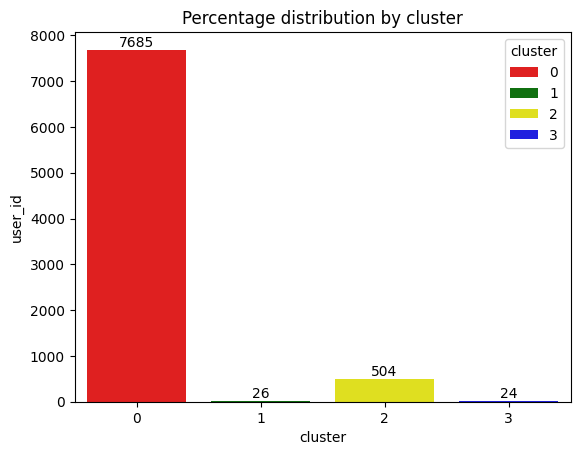

In [ ]:
ax=sns.barplot(
    x="cluster",
    y="user_id",
    hue="cluster",
    data=temp,
    errwidth=5,  # Customize error bar width as needed
    capsize=7,  # Adjust error bar cap size
    palette=colors,
    linewidth=2
)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Percentage distribution by cluster')

In [ ]:
account='''  SELECT t.id user_id,
  t.acountmgr_user_id,
  t.product_plan,
  a.name,
  t.company_name,
  t.country tenant_country,
  t.status,
  FROM `adventus-analytics.dw_v2.tenants` t
  LEFT JOIN `adventus-analytics.salesforce.accounts` a
  ON CAST(t.acountmgr_user_id AS STRING)= a.client_id_c
  WHERE acountmgr_user_id IS NOT NULL '''

In [ ]:
query_job = client.query(account)
rows = query_job.result()
acc=rows.to_dataframe()
acc.columns

Index(['user_id', 'acountmgr_user_id', 'product_plan', 'name', 'company_name',
       'tenant_country', 'status'],
      dtype='object')

In [ ]:
df.shape

(8279, 8)

In [ ]:
acc.shape

(10095, 6)

In [ ]:
merged = df.merge(acc,how='left',left_on='user_id',right_on='user_id')
merged.shape

(8279, 14)

In [ ]:
df['user_id'].nunique()

8279

In [ ]:
x = merged.groupby(['status'])['user_id'].nunique().reset_index()
x

status  user_id
0     Active     2441
1     Closed       11
2    Pending      388
3  Suspended       14

In [ ]:
x = merged.loc[merged['cluster']==1,].groupby(['tenant_country'])['acountmgr_user_id'].nunique().reset_index()
x

tenant_country  acountmgr_user_id
0          India                  4
1          Japan                  1
2        Nigeria                  1
3      Sri Lanka                  1
4       Thailand                  1

In [ ]:
x = merged.loc[merged['cluster']==2,].groupby(['tenant_country'])['user_id'].nunique().reset_index()
x

tenant_country  user_id
0           Aruba        1
1       Australia       14
2      Bangladesh       19
3          Brazil        2
4        Cambodia        1
5        Colombia        2
6         Ecuador        1
7       Hong Kong        3
8           India       81
9       Indonesia        5
10       Malaysia        2
11        Myanmar        1
12          Nepal       18
13        Nigeria       11
14       Pakistan       21
15   Saudi Arabia        1
16    South Korea        3
17      Sri Lanka        9
18       Thailand        3
19        Vietnam       19